# Facial Recognition using FaceNet:
## Can my face be recognized?
---
Fascinated by the facial recognition technology, I tested the pretrained facial recognition model [FaceNet](https://github.com/timesler/facenet-pytorch), which was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset with my photos. I started with the examples used in Neuromatch Academy Deep Learning online summer school 2021 (I was a teaching assistant there!), and then showed you how well the model could recognized my face.

## Setup

In [91]:
# Install dependencies
# Install `facenet` - a model used to do facial recognition

# pip install
!pip install facenet-pytorch --quiet
!pip install Pillow --quiet

# git clone (alternative installation especially in HPC) 
#!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch
#!git clone https://aur.archlinux.org/python-pillow-git.git Pillow

In [92]:
# Import packages
import glob
import torch

import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

from PIL import Image

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from facenet_pytorch import MTCNN, InceptionResnetV1

In [93]:
# Set random seed
# Executing `set_seed(seed=seed)` you are setting the seed
# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [94]:
# Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [95]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


---
## Data processing
### Part 1: Download and prepare the data

In [96]:
# Download Data
import requests, zipfile, io, os

# original link: https://github.com/ben-heil/cis_522_data.git
# url = 'https://osf.io/2kyfb/download'
url = 'https://github.com/myyim/dataset/raw/main/faces.zip'

fname = 'faces'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


### Part 2: View and transform the data

MTCNN ([github repo](https://github.com/ipazc/mtcnn)) detects the face and crops the image around the face.

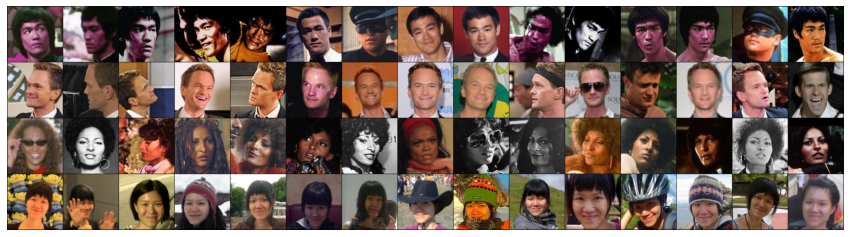

In [97]:
# Display Images
# Here are the source images of Bruce Lee, Neil Patrick Harris, Pam Grier and me
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder('faces', transform=train_transform)

image_count = len(face_dataset)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=75,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = dataiter.next()

images_to_display = torch.cat((images[0:15,:,:,:],images[30:,:,:,:],images[15:30,:,:,:]))
# show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [98]:
# Image Preprocessing Function
def process_images(image_dir: str, size=256):
  """
  This function returns two tensors for the given image dir: one usable for inputting into the
  facenet model, and one that is [0,1] scaled for visualizing

  Parameters:
    image_dir: The glob corresponding to images in a directory

  Returns:
    model_tensor: A image_count x channels x height x width tensor scaled to between -1 and 1,
                  with the faces detected and cropped to the center using mtcnn
    display_tensor: A transformed version of the model tensor scaled to between 0 and 1
  """
  mtcnn = MTCNN(image_size=size, margin=32)
  images = []
  for img_path in glob.glob(image_dir):
    img = Image.open(img_path)
    # Normalize and crop image
    img_cropped = mtcnn(img)
    images.append(img_cropped)

  model_tensor = torch.stack(images)
  display_tensor = model_tensor / (model_tensor.max() * 2)
  display_tensor += .5

  return model_tensor, display_tensor

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


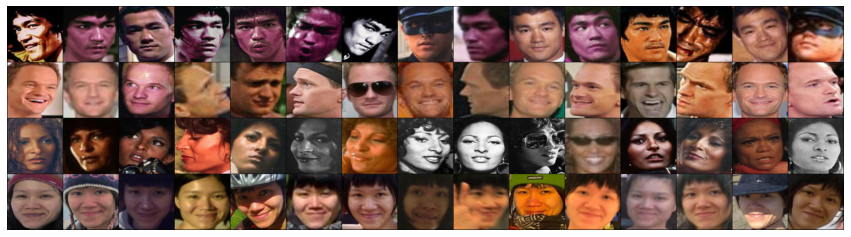

In [99]:
# Crop the images
bruce_tensor, bruce_display = process_images('faces/bruce/*.jpg')
neil_tensor, neil_display = process_images('faces/neil/*.jpg')
pam_tensor, pam_display = process_images('faces/pam/*.jpg')
manyi_tensor, manyi_display = process_images('faces/manyi/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display, manyi_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Part 3: Embedding with a pretrained network 

We use the pretrained facial recognition model called [FaceNet](https://github.com/timesler/facenet-pytorch) to calculate embeddings for all of our input images.

In [100]:
# Calculate embedding: 512-dimensional normalized vectors
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(DEVICE))
neil_embeddings = resnet(neil_tensor.to(DEVICE))
pam_embeddings = resnet(pam_tensor.to(DEVICE))
manyi_embeddings = resnet(manyi_tensor.to(DEVICE))

In [101]:
# Project the 512 dimensions onto a 2D space using Principal Component Analysis (PCA)
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings,
                              manyi_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

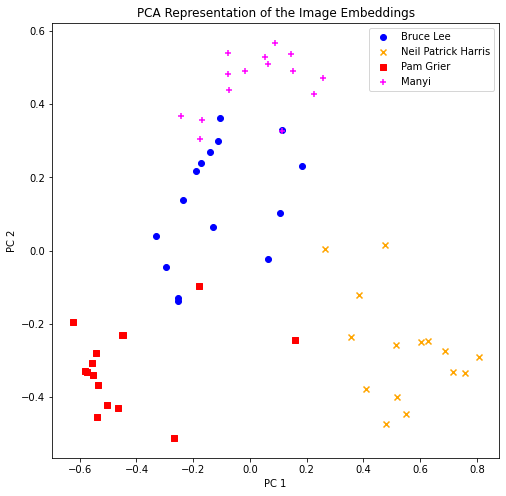

In [102]:
# PCA
num = 15
categs = 4
colors = ['blue', 'orange', 'red', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier', 'Manyi']
markers = ['o', 'x', 's', '+']
plt.figure(figsize=(8, 8))
for i in range(categs):
   plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

## Similarity and dissimilarity measures for faces


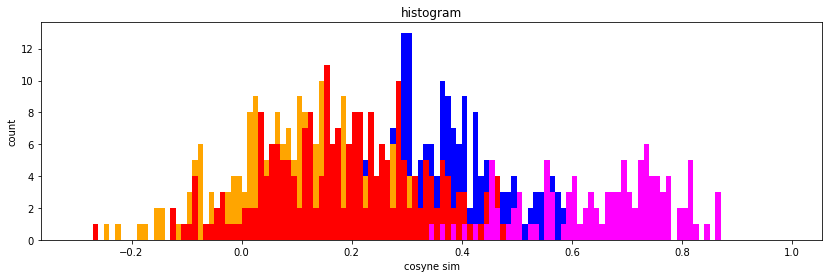

In [107]:
# Similarity using cosine or dot product
# (Since the embedding tensors are normalized, the two are equivalent)
sim_within = []
sim_across = [[],[],[]]
for j in range(15):
    for k in range(j+1,15):
        sim_within.append(np.dot(manyi_embeddings[j,:].detach().numpy(),manyi_embeddings[k,:].detach().numpy()))
        
for j in range(15):
    for k in range(15):
        sim_across[0].append(np.dot(manyi_embeddings[j,:].detach().numpy(),bruce_embeddings[k,:].detach().numpy()))
        sim_across[1].append(np.dot(manyi_embeddings[j,:].detach().numpy(),neil_embeddings[k,:].detach().numpy()))
        sim_across[2].append(np.dot(manyi_embeddings[j,:].detach().numpy(),pam_embeddings[k,:].detach().numpy()))
        
plt.figure(figsize=(14, 4))
for j in range(3):
    plt.hist(sim_across[j],np.arange(-0.3,1,0.01),color=colors[j])
plt.hist(sim_within,np.arange(-0.3,1,0.01),color=colors[3])
plt.title('histogram')
plt.xlabel('cosyne sim')
plt.ylabel('count')
plt.show()    

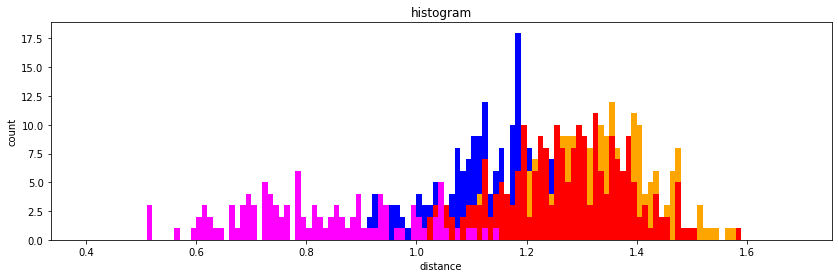

In [108]:
# Dissimilarity using Euclidean distance
dis_within = []
dis_across = [[],[],[]]
for j in range(15):
    for k in range(j+1,15):
        dis_within.append(np.linalg.norm((manyi_embeddings[j,:]-manyi_embeddings[k,:]).detach().numpy()))
        
for j in range(15):
    for k in range(15):
        dis_across[0].append(np.linalg.norm((manyi_embeddings[j,:]-bruce_embeddings[k,:]).detach().numpy()))
        dis_across[1].append(np.linalg.norm((manyi_embeddings[j,:]-neil_embeddings[k,:]).detach().numpy()))
        dis_across[2].append(np.linalg.norm((manyi_embeddings[j,:]-pam_embeddings[k,:]).detach().numpy()))
        
plt.figure(figsize=(14, 4))
for j in range(3):
    plt.hist(dis_across[j],np.arange(0.4,1.7,0.01),color=colors[j])
plt.hist(dis_within,np.arange(0.4,1.7,0.01),color=colors[3])
plt.title('histogram')
plt.xlabel('distance')
plt.ylabel('count')
plt.show()    